In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import sys
import os

sys.path.append(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('.')))
if project_root not in sys.path:
    sys.path.append(project_root)

from train.calibrator import config as calibrator_config
from train.calibrator.data_generator import generate_calibration_data
from src.logger import logger

In [2]:
try:
    # Load the trained calibrator model
    model_path = os.path.join(calibrator_config.MODEL_OUTPUT_DIR, calibrator_config.MODEL_NAME)
    calibrator = joblib.load(model_path)
    logger.info(f"Loaded calibrator model from {model_path}")

    # Generate the dataset: raw confidences (X) and true outcomes (y)
    raw_confidences, true_outcomes = generate_calibration_data()
    if raw_confidences is None:
        raise FileNotFoundError("Could not generate calibration data.")
        
except FileNotFoundError as e:
    logger.error(f"Error: {e}. Please run the full training pipeline first.")

2025-10-07 23:00:05,358 - AgenticReasoningPipeline - INFO - Loaded calibrator model from e:\agentic-reasoning-engine\models\confidence_calibrator.pkl (802096479.py:5)
2025-10-07 23:00:05,359 - AgenticReasoningPipeline - INFO - Generating data for confidence calibrator... (data_generator.py:20)
2025-10-07 23:00:05,367 - AgenticReasoningPipeline - INFO - Loading data for classifier training... (data_loader.py:22)
2025-10-07 23:00:05,386 - AgenticReasoningPipeline - INFO - Data loading complete. Train size: 307, Val size: 77 (data_loader.py:45)
2025-10-07 23:00:05,390 - AgenticReasoningPipeline - INFO - Calibration data generated successfully. (data_generator.py:64)


In [3]:
# The calibrator's predict_proba method returns probabilities for [class 0, class 1]
# We want the probability of class 1 (i.e., the prediction being correct)
calibrated_probs = calibrator.predict_proba(raw_confidences.reshape(-1, 1))[:, 1]

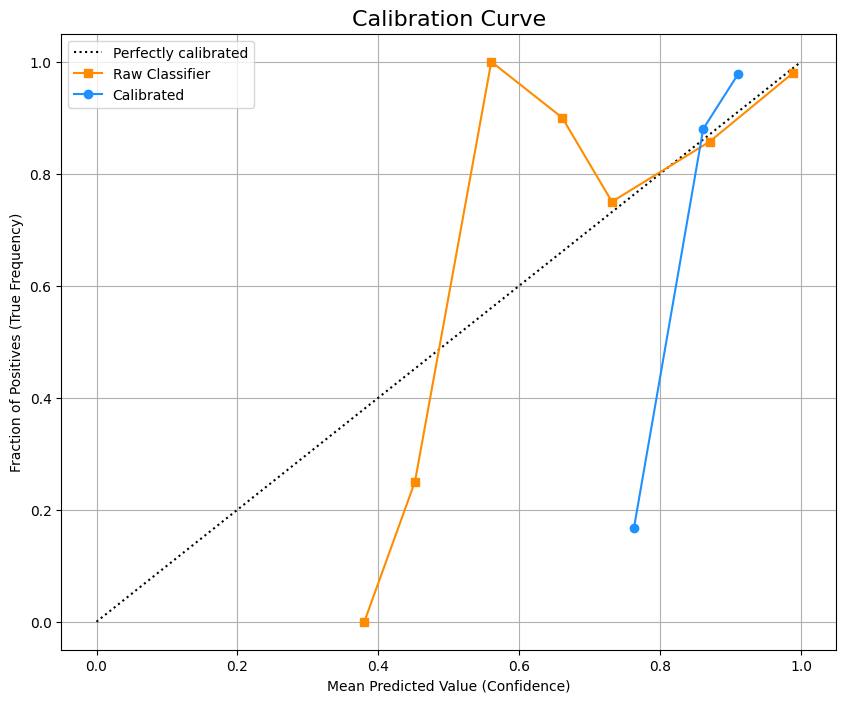

In [4]:
# Get points for the calibration curve for both raw and calibrated probabilities
fraction_of_positives_raw, mean_predicted_value_raw = calibration_curve(true_outcomes, raw_confidences, n_bins=10)
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(true_outcomes, calibrated_probs, n_bins=10)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

plt.plot(mean_predicted_value_raw, fraction_of_positives_raw, 's-', label='Raw Classifier', color='darkorange')
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, 'o-', label='Calibrated', color='dodgerblue')

plt.title('Calibration Curve', fontsize=16)
plt.ylabel('Fraction of Positives (True Frequency)')
plt.xlabel('Mean Predicted Value (Confidence)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
sample_confidences = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
calibrated_samples = calibrator.predict_proba(sample_confidences.reshape(-1, 1))[:, 1]

print("--- Calibrator Test ---")
for raw, cal in zip(sample_confidences, calibrated_samples):
    print(f"Raw Confidence: {raw:.2f} -> Calibrated Probability of being correct: {cal:.2f}")

--- Calibrator Test ---
Raw Confidence: 0.50 -> Calibrated Probability of being correct: 0.79
Raw Confidence: 0.60 -> Calibrated Probability of being correct: 0.82
Raw Confidence: 0.70 -> Calibrated Probability of being correct: 0.85
Raw Confidence: 0.80 -> Calibrated Probability of being correct: 0.87
Raw Confidence: 0.90 -> Calibrated Probability of being correct: 0.89
Raw Confidence: 0.99 -> Calibrated Probability of being correct: 0.91


In [7]:
def analyze_calibration_improvement():
    """Quantify the improvement from calibration."""
    print("CALIBRATION IMPROVEMENT ANALYSIS")
    print("=" * 60)
    
    # Calculate calibration errors
    def calibration_error(fraction_positives, mean_predictions):
        return np.mean((fraction_positives - mean_predictions) ** 2)
    
    error_raw = calibration_error(fraction_of_positives_raw, mean_predicted_value_raw)
    error_cal = calibration_error(fraction_of_positives_cal, mean_predicted_value_cal)
    
    improvement = ((error_raw - error_cal) / error_raw) * 100
    
    print(f"Raw Classifier Calibration Error: {error_raw:.4f}")
    print(f"Calibrated Model Calibration Error: {error_cal:.4f}")
    print(f"Improvement: {improvement:.1f}% reduction in error")
    
    # Brier score analysis
    from sklearn.metrics import brier_score_loss
    brier_raw = brier_score_loss(true_outcomes, raw_confidences)
    brier_cal = brier_score_loss(true_outcomes, calibrated_probs)
    
    print(f"\nBrier Score (Lower is Better):")
    print(f"Raw Classifier: {brier_raw:.4f}")
    print(f"Calibrated Model: {brier_cal:.4f}")
    print(f"Brier Score Improvement: {((brier_raw - brier_cal) / brier_raw) * 100:.1f}%")
    
    return error_raw, error_cal, brier_raw, brier_cal

# Run calibration analysis
error_raw, error_cal, brier_raw, brier_cal = analyze_calibration_improvement()

CALIBRATION IMPROVEMENT ANALYSIS
Raw Classifier Calibration Error: 0.0623
Calibrated Model Calibration Error: 0.1201
Improvement: -92.6% reduction in error

Brier Score (Lower is Better):
Raw Classifier: 0.0670
Calibrated Model: 0.0872
Brier Score Improvement: -30.2%


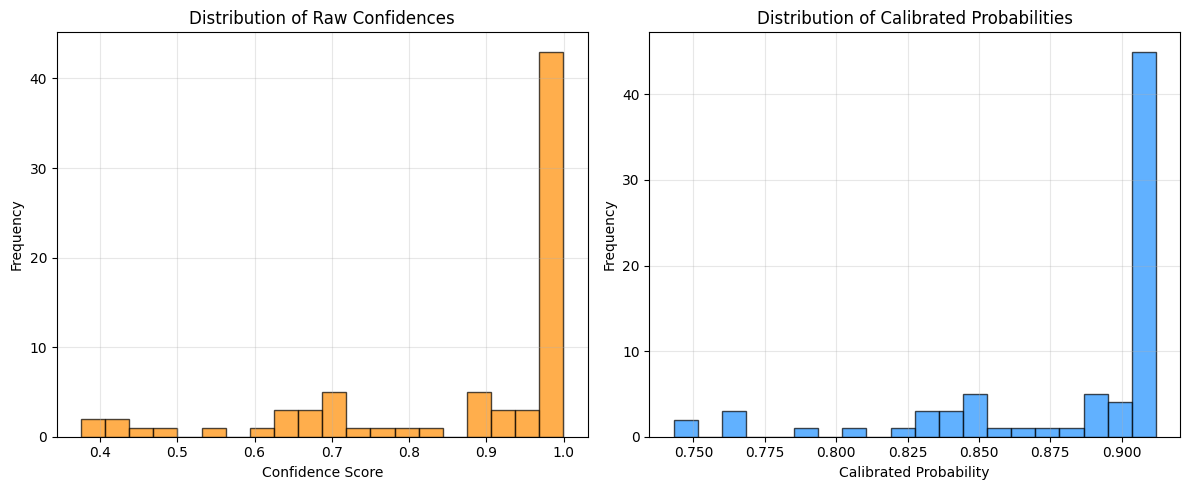

CONFIDENCE DISTRIBUTION STATISTICS
Raw Confidences - Mean: 0.873, Std: 0.181
Calibrated Probs - Mean: 0.883, Std: 0.045


In [8]:
def plot_confidence_distributions():
    """Plot the distribution of raw vs calibrated confidences."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(raw_confidences, bins=20, alpha=0.7, color='darkorange', edgecolor='black')
    plt.title('Distribution of Raw Confidences')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(calibrated_probs, bins=20, alpha=0.7, color='dodgerblue', edgecolor='black')
    plt.title('Distribution of Calibrated Probabilities')
    plt.xlabel('Calibrated Probability')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("CONFIDENCE DISTRIBUTION STATISTICS")
    print("=" * 50)
    print(f"Raw Confidences - Mean: {np.mean(raw_confidences):.3f}, Std: {np.std(raw_confidences):.3f}")
    print(f"Calibrated Probs - Mean: {np.mean(calibrated_probs):.3f}, Std: {np.std(calibrated_probs):.3f}")

plot_confidence_distributions()

In [9]:
def create_reliability_table():
    """Create a table showing reliability of confidence bins."""
    print("RELIABILITY TABLE")
    print("=" * 70)
    print(f"{'Confidence Bin':<15} {'Raw Accuracy':<15} {'Calibrated Accuracy':<20} {'Samples':<10}")
    print("-" * 70)
    
    bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    for i in range(len(bins) - 1):
        low, high = bins[i], bins[i+1]
        
        # Raw confidence analysis
        raw_mask = (raw_confidences >= low) & (raw_confidences < high)
        if np.sum(raw_mask) > 0:
            raw_accuracy = np.mean(true_outcomes[raw_mask])
        else:
            raw_accuracy = 0
        
        # Calibrated confidence analysis
        cal_mask = (calibrated_probs >= low) & (calibrated_probs < high)
        if np.sum(cal_mask) > 0:
            cal_accuracy = np.mean(true_outcomes[cal_mask])
        else:
            cal_accuracy = 0
        
        samples_raw = np.sum(raw_mask)
        samples_cal = np.sum(cal_mask)
        
        print(f"{low:.1f}-{high:.1f}:     {raw_accuracy:.3f}          {cal_accuracy:.3f}                 {samples_raw:<10}")

# Generate reliability table
create_reliability_table()

RELIABILITY TABLE
Confidence Bin  Raw Accuracy    Calibrated Accuracy  Samples   
----------------------------------------------------------------------
0.0-0.5:     0.167          0.000                 6         
0.5-0.6:     1.000          0.000                 1         
0.6-0.7:     0.900          0.000                 10        
0.7-0.8:     0.750          0.167                 4         
0.8-0.9:     0.857          0.880                 7         
0.9-1.0:     0.980          0.978                 49        
